In [15]:
import torch
import torchaudio

In [19]:
label = torch.LongTensor(4, 4, 1).random_() % 10

In [20]:
one_hot = torch.zeros(4, 4, 10).scatter_(2, label, 1)

In [21]:
one_hot

tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]])

In [1]:


import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from util import TUTDataset
from model import SELDNet
from pprint import pprint

import argparse
import sys
import os

IR_SET = ["ir0","ir1","ir2","ir3","ir4"]
SPLIT_SET = ["split1","split2"]
OV_SET = ["ov1"]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size=4


tutdata = TUTDataset("data/mic_dev","data/metadata_dev",sample_freq=44100,split_set=SPLIT_SET,ir_set=IR_SET,ov_set=OV_SET)
tutloader = data.DataLoader(tutdata,batch_size=batch_size,shuffle=True)
evaldata = TUTDataset("data/mic_dev","data/metadata_dev",sample_freq=44100,split_set=["split3"],ir_set=IR_SET,ov_set=OV_SET)
evalloader = iter(data.DataLoader(evaldata,batch_size=batch_size,shuffle=False))
sample_eval, sed_eval, doa_eval = next(evalloader)
# !!已验证单解码函数在eval数据上工作正常
sed_eval_onehot = torch.zeros((4,5160,12)).scatter_(2,sed_eval.unsqueeze(2),1)
sample_eval = sample_eval.to(device)
sed_eval = sed_eval.to(device)
doa_eval = doa_eval.to(device)
sed_eval_predict = None

model = SELDNet(K=tutdata.num_class)
model.to(device)
model.train()
print(model)
criterion_sed = nn.CrossEntropyLoss()
criterion_doa = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

epoch_num = 4
min_loss = 100
train_loss_sum = 0
steps = 0
save_step = 5
for epoch in range(epoch_num):
    for sample,sed,doa in tutloader:
        sample = sample.to(device)
        sed = sed.to(device)
        doa = doa.to(device)
        print("steps {}".format(steps))
        optimizer.zero_grad()
        out_sed,out_doa = model(sample)
        out_sed = out_sed.reshape(-1,tutdata.num_class)
        sed = sed.reshape(-1)
        loss_sed = criterion_sed(out_sed,sed)
        # loss_doa = criterion_doa(out_doa.double(),doa.double())
        loss = loss_sed #+loss_doa
        train_loss_sum += float(loss)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),2) # 防止梯度爆炸
        optimizer.step()

        # evaluation
        if steps % save_step==0:
            model.eval()
            with torch.no_grad():
                out_sed,out_doa = model(sample_eval)
                sed_eval_predict = out_sed
                out_sed = out_sed.reshape(-1,tutdata.num_class)
                sed_eval = sed_eval.reshape(-1)
                loss_sed = criterion_sed(out_sed,sed_eval)
                loss_doa = criterion_doa(out_doa.double(),doa_eval.double())
                loss = loss_sed+loss_doa
                print("train loss: {}, evaluation loss: {}".format(float(train_loss_sum)/save_step,float(loss)))
                if float(loss)<min_loss:
                    print("saveing model...")
                    min_loss = float(loss)
                    torch.save(model.state_dict(),"SELDNet-best2.ckpt")
                train_loss_sum = 0
            model.train()

        steps+=1

SELDNet(
  (conv0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (sed_fc0): Linear(in_features=32, out_features=16, bias=True)
  (sed_fc1): Linear(in_features=16, out_features=12, bias=True)
  (doa_fc0): Linear(in_features=32, out_features=16, bias=True)
  (doa_fc1): Linear(in_features=16, out_features=36, bias=True)
)
steps 0
train loss: 0.5047904968261718, evaluation loss: 3.062437914498288
saveing model...
steps 1
steps 2
steps 3
steps 4
steps 5
train loss: 2.448518180847168, evaluation loss: 2.81113354233411
saveing model...
steps 6
steps 7
ste

KeyboardInterrupt: 

In [7]:
sed_eval_onehot[0]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
sed_eval_predict[0]

tensor([[0.2973, 0.4494, 0.3179,  ..., 0.2446, 0.2119, 0.3897],
        [0.9396, 0.0069, 0.6793,  ..., 0.0053, 0.0586, 0.7296],
        [0.9821, 0.0506, 0.1842,  ..., 0.1584, 0.5095, 0.2317],
        ...,
        [0.0085, 0.8028, 0.0189,  ..., 0.5916, 0.9458, 0.2092],
        [0.1443, 0.2317, 0.4111,  ..., 0.0520, 0.2718, 0.3342],
        [0.4514, 0.0536, 0.3408,  ..., 0.0140, 0.2911, 0.3459]],
       device='cuda:0')

In [4]:
import matplotlib.pyplot as plt
import numpy as np

{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11}


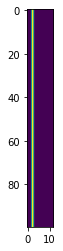

In [5]:
tmp = sed_eval_onehot[0].cpu().numpy()
start=20
plt.imshow(tmp[start*100:start*100+100,:])
print(set(np.argmax(tmp,1)))

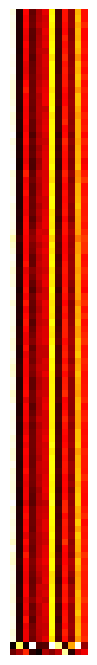

In [13]:
tmp = sed_eval_predict[0].cpu().numpy()
start=0
plt.figure(figsize=(1,50),dpi=100)
plt.imshow(tmp[-1-100:-1,:],interpolation='nearest', cmap=plt.cm.hot)
plt.axis('off')
plt.savefig("tmp.jpg",dpi=100)

### 检查STFT特征
**自己实现的能量谱没有错**

*相位谱有点问题*

matplotlib的相位谱怎么有这么大的数字？？

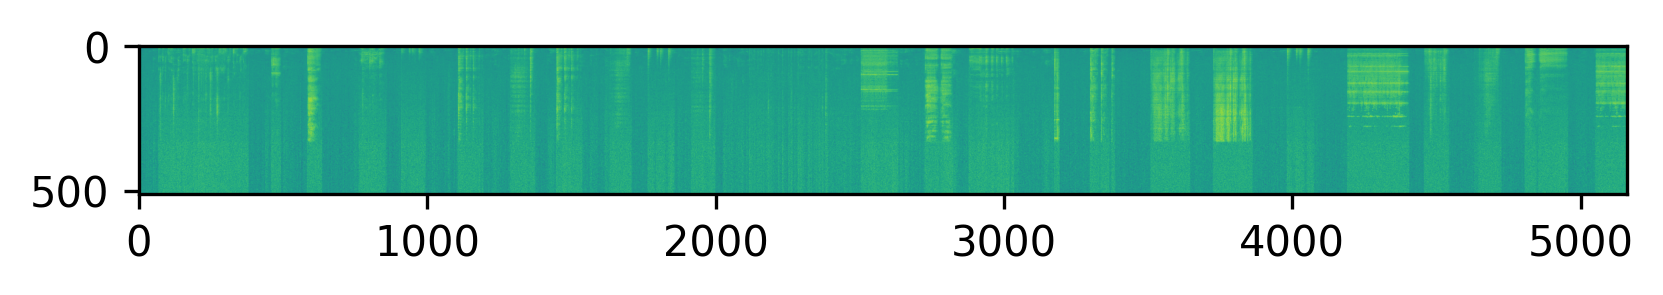

In [2]:
import matplotlib.pyplot as plt
from util import getDFTFeature
import torchaudio
filename = "split3_ir4_ov1_87.wav"
filepath = "data/mic_dev/split3_ir4_ov1_87.wav"
res = getDFTFeature(filepath)
plt.figure(figsize=(6.4,4.8),dpi=300)
plt.imshow(res[1].T)
plt.show()

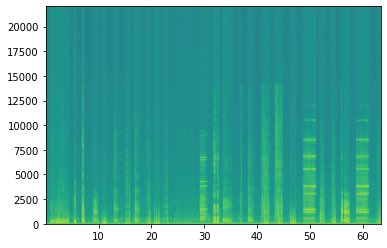

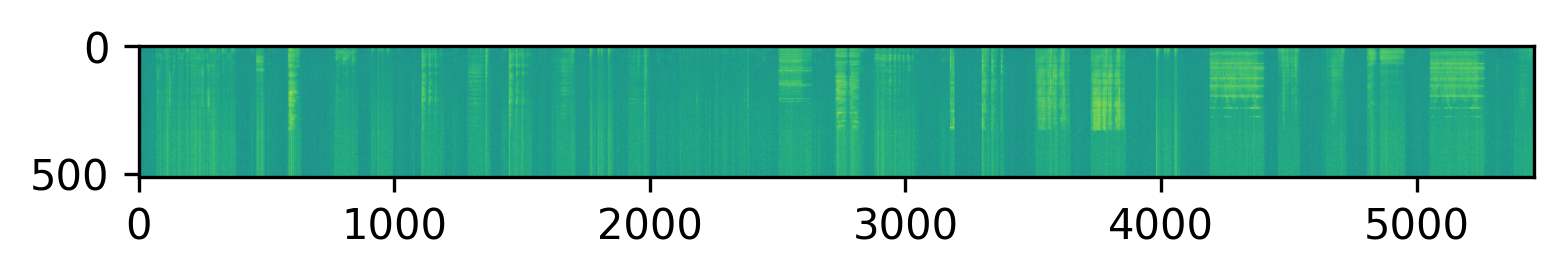

In [3]:
import matplotlib.pyplot as plt
import numpy as np
waveform, sample_freq = torchaudio.load(filepath)
spectrum,freqs,t,im = plt.specgram(waveform[1,:],NFFT=1024,noverlap=512,window=np.hamming(1024),Fs=44100,mode='psd')
spectrum = 10*np.log10(spectrum)
mean_vec = np.mean(spectrum,axis=1,keepdims=True)
std_vec = np.std(spectrum,axis=1,keepdims=True)
spectrum = (spectrum-mean_vec)/std_vec
plt.figure(dpi=300)
plt.imshow(spectrum)

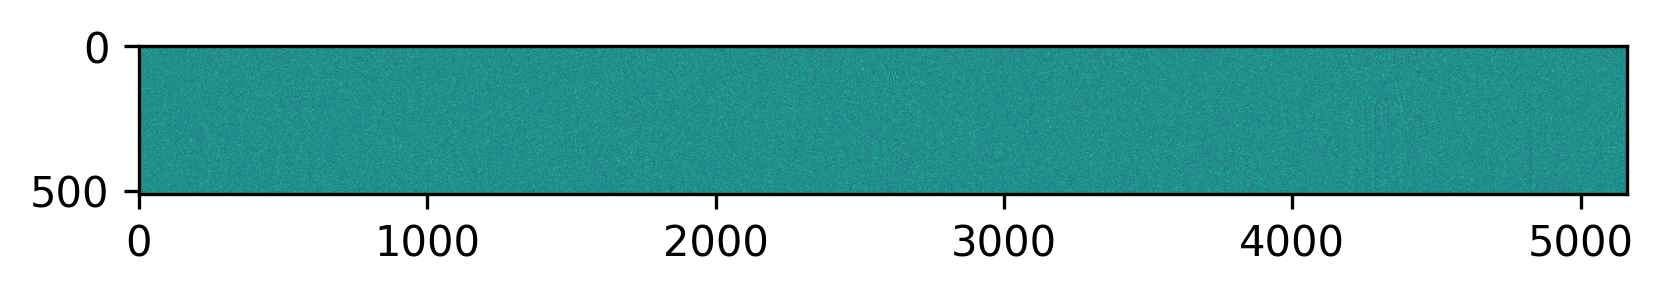

In [4]:
import matplotlib.pyplot as plt
from util import getDFTFeature
import torchaudio
filename = "split3_ir4_ov1_87.wav"
filepath = "data/mic_dev/split3_ir4_ov1_87.wav"
res = getDFTFeature(filepath)
plt.figure(figsize=(6.4,4.8),dpi=300)
plt.imshow(res[4].T)
plt.show()

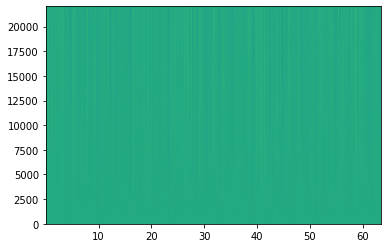

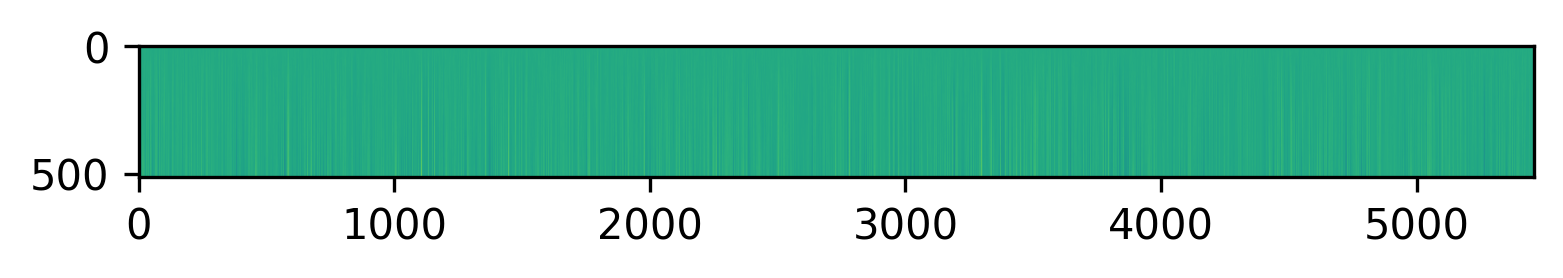

In [5]:
import matplotlib.pyplot as plt
import numpy as np
waveform, sample_freq = torchaudio.load(filepath)
spectrum,freqs,t,im = plt.specgram(waveform[1,:],NFFT=1024,noverlap=512,window=np.hamming(1024),Fs=44100,mode='phase')

plt.figure(dpi=300)
plt.imshow(spectrum)

In [6]:
spectrum

array([[   3.14159265,    3.14159265,    3.14159265, ...,    3.14159265,
           3.14159265,    3.14159265],
       [   6.10464021,    0.26411417,    5.94980214, ...,    3.95174739,
           1.7394344 ,    6.05896794],
       [   4.0070019 ,   -2.6766226 ,    7.72322038, ...,    6.74321449,
           4.76627968,    8.74656214],
       ...,
       [ 118.69677454,  -39.20241633,   84.50640689, ..., -136.35405286,
          -0.46968604,  -28.00923145],
       [ 120.07584264,  -38.17034009,   86.18390826, ..., -136.84971046,
           0.90432018,  -25.2152305 ],
       [ 122.52211349,  -40.8407045 ,   87.9645943 , ..., -138.23007676,
           0.        ,  -28.27433388]])